In [1]:
import numpy as np
import pandas as pd
import sklearn.covariance
import scipy.stats
from scipy.stats import gmean
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class IBBSeqLabeler:
    def __init__(self, counts, min_sig_count, alpha=1e-3):  
        self.mapped= counts.iloc[:-1]
        psuedo_count = 1
        self.min_log_std = 1.
        self.log_mapped = np.log(self.mapped + psuedo_count)
        self.alpha = alpha
        self.min_sig_count = min_sig_count

    def _fit(self, log_mapped):
        cov = sklearn.covariance.EllipticEnvelope(
                contamination=0.1,
                random_state=0)
        cov.fit(log_mapped.values[:, None])
        return cov

    def run(self):
        try:
            self._cov = self._fit(self.log_mapped)
            self.bg_loc = np.ravel(self._cov.location_)
            self.bg_prec = np.ravel(self._cov.precision_)
        except ValueError as e:
            self.bg_loc = self.log_mapped.mean()
            self.bg_prec = 1./ min(self.log_mapped.std(ddof=1), self.min_log_std)
        self.bg_z_values = (self.log_mapped - self.bg_loc) * self.bg_prec
        self.bg_probs = np.where(self.mapped >= self.min_sig_count, 1 - scipy.stats.norm.cdf(self.bg_z_values), 1)
        self.signals = self.bg_probs <= self.alpha

    def get_signals(self):
        return self.signals

    def get_bg_probs(self):
        return self.bg_probs

In [3]:
class IBBSeqTableLabeler:
    def __init__(self, table, min_sig_count, min_total_count):
        
        if min_total_count:
            table = table.loc[:, table.sum(axis=0) >= min_total_count]
        self.table = table  
        self.labelers = [IBBSeqLabeler(self.table[cell], min_sig_count=min_sig_count) for cell in self.table.columns]
   
    def run(self):

        for labeler in tqdm.tqdm(self.labelers):
            labeler.run()
        self.signals = np.asarray([l.get_signals() for l in self.labelers], dtype=int).T  
        self.bg_probs = np.asarray([l.get_bg_probs() for l in self.labelers]).T  

    def save(self, out_prefix):
        output = out_prefix + '.signals.txt.gz'
        tab = pd.DataFrame(self.signals, index=self.table[:-1].index, columns=self.table.columns)
        tab.to_csv(output, sep='\t', compression='gzip')

        pos_sel = self.signals.sum(axis=0) > 0
        pos_columns = self.table.columns.values[pos_sel]
        pos_signals = self.signals[:, pos_sel]
        output = out_prefix + '.pos_signals.txt.gz'
        tab = pd.DataFrame(pos_signals, index=self.table[:-1].index, columns=pos_columns)
        tab.to_csv(output, sep='\t', compression='gzip')

        output = out_prefix + '.bg_probs.txt.gz'
        tab = pd.DataFrame(self.bg_probs, index=self.table[:-1].index, columns=self.table[:-1].columns)
        tab.to_csv(output, float_format='%.6g', sep='\t', compression='gzip')


In [4]:
dense_umis = 'PATH_TO_BARCODE_COUNT'

In [5]:
out_folder = 'PATH_TO_FOLDER'

In [6]:
out_prefix = out_folder + 'fk209_2022-05-24-10X'
min_total_count = 50
min_sig_count = 25
alpha = "1e-3" 
out_path =  out_prefix + '_' + alpha + '_th' + str(min_total_count) + "_ee"

In [7]:
tab = pd.read_csv(dense_umis, sep='\t', index_col=0)
tab.shape

(59, 7358)

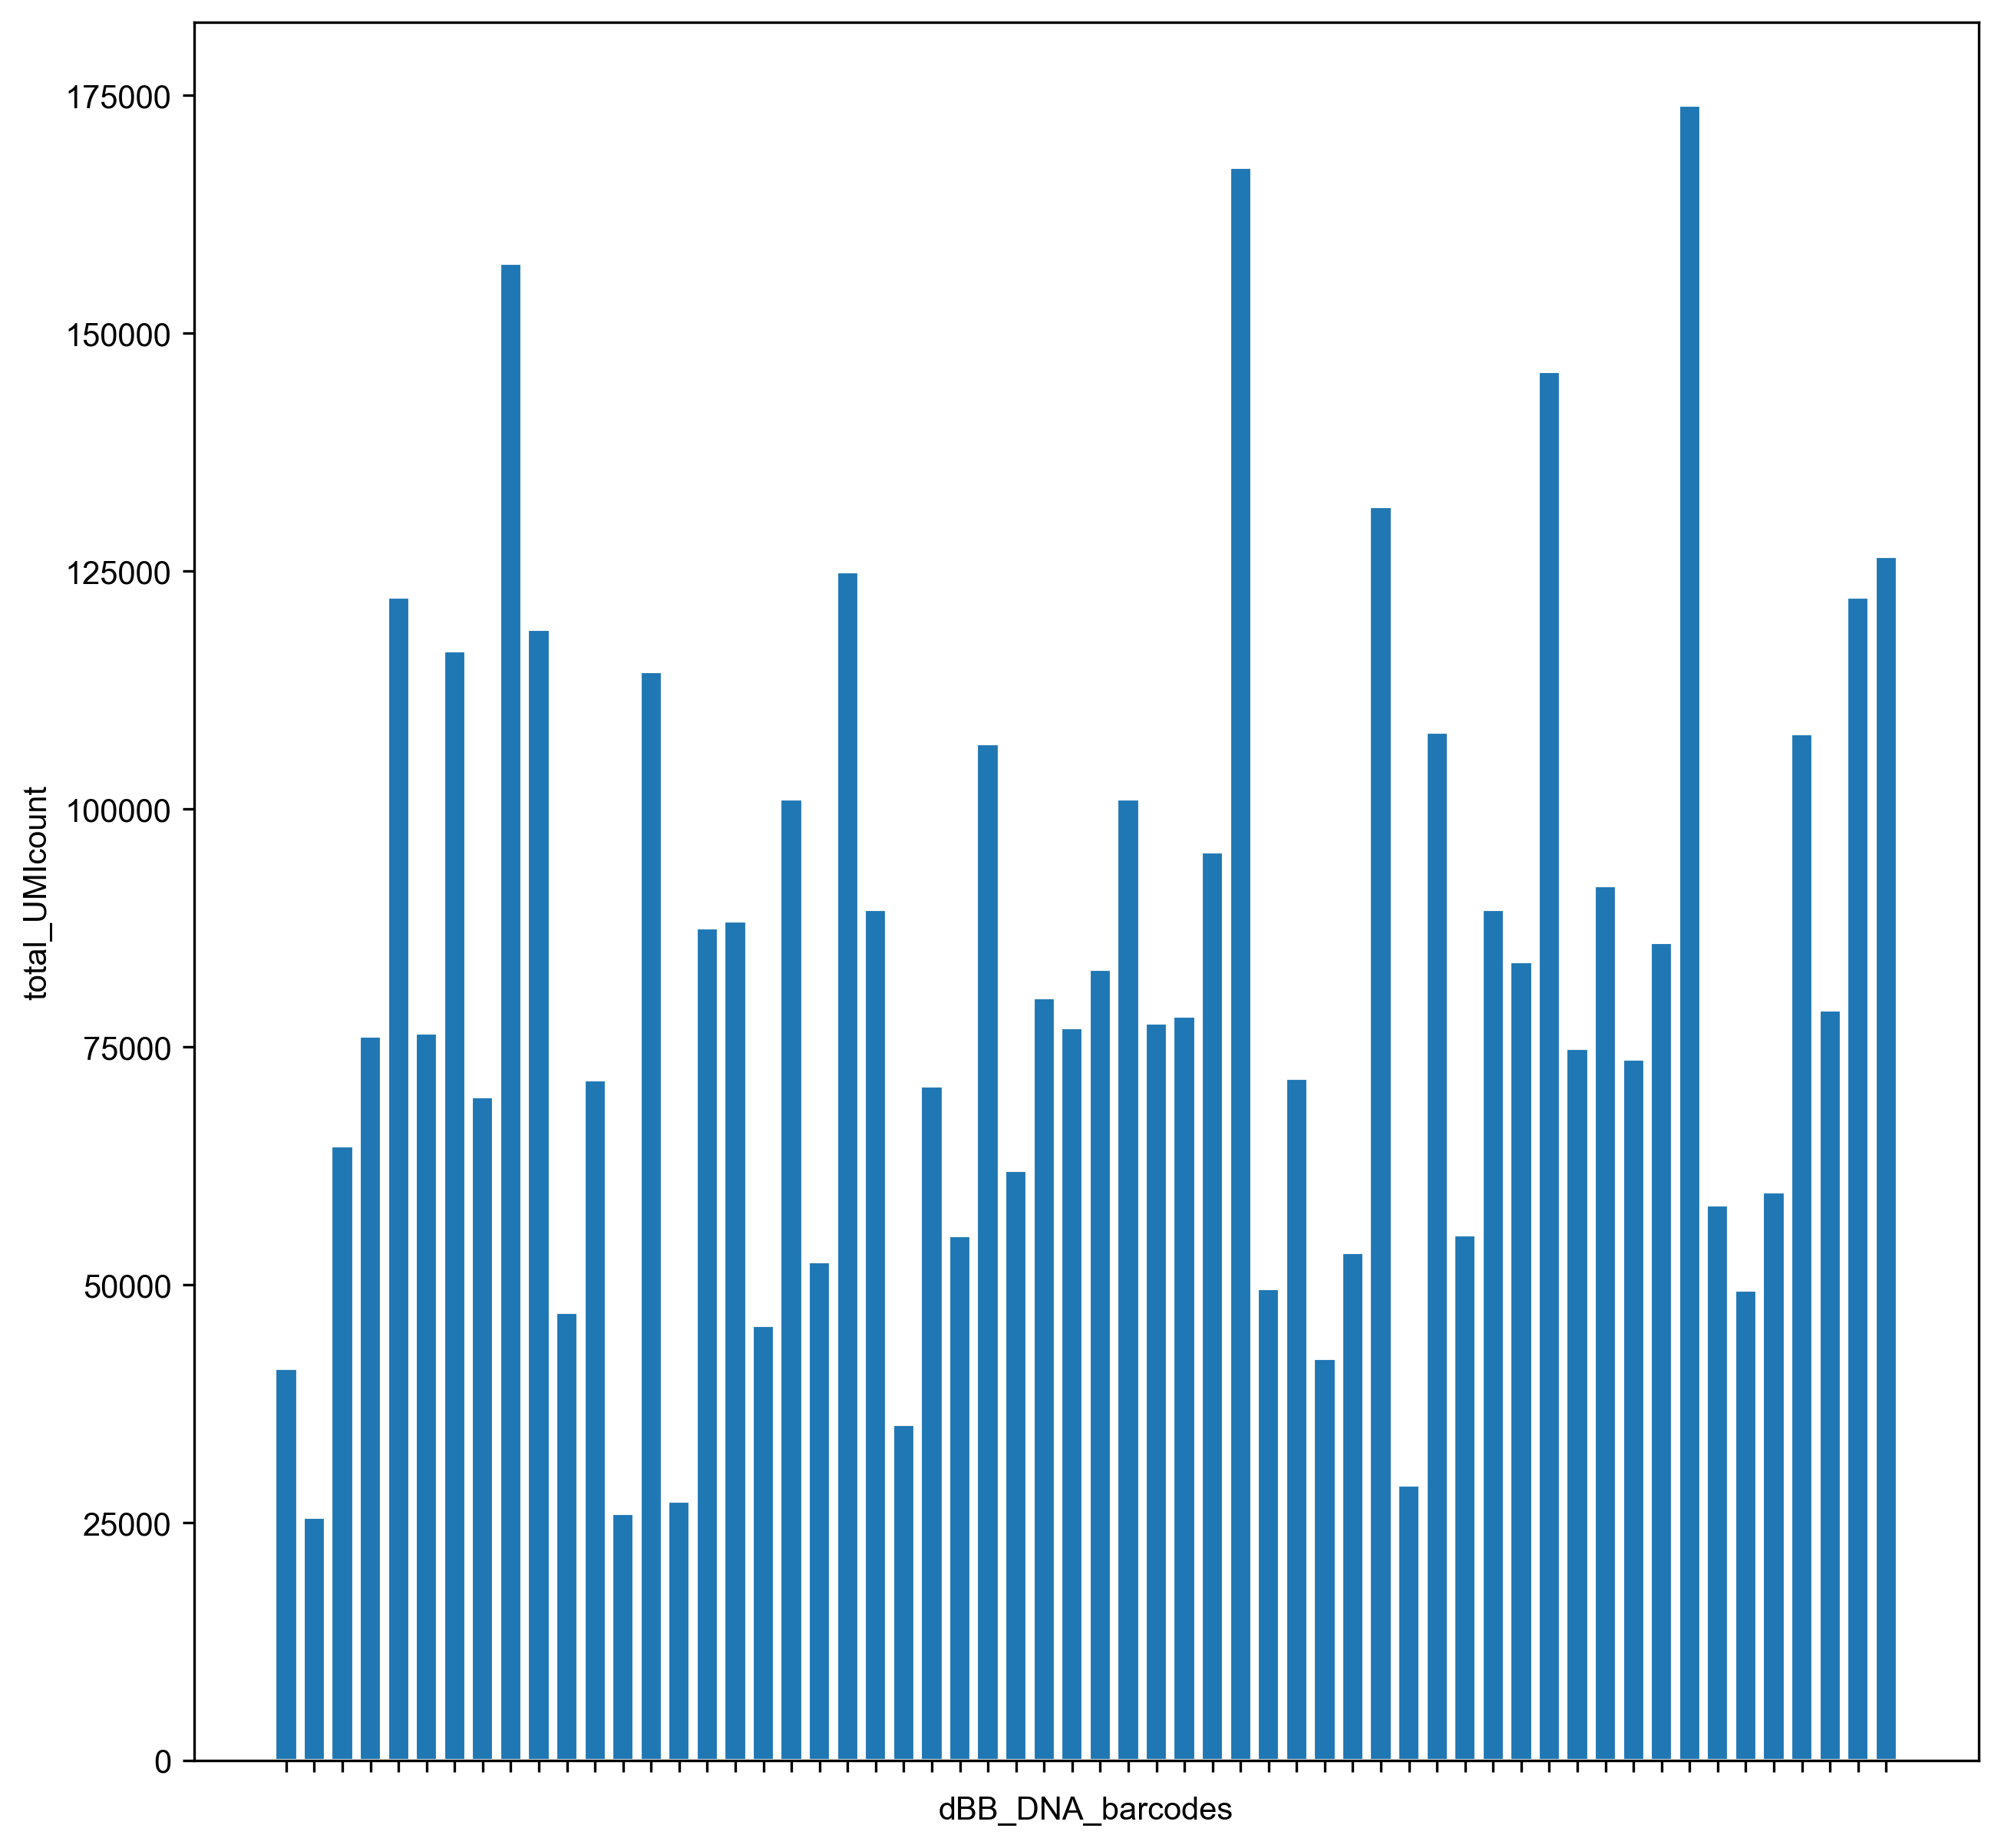

In [8]:
#Plotting total count (removing 'unmapped')
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
sns.set()
ax.bar(tab[0:58].index, tab[0:58].sum(axis=1))
ax.set_ylabel('total_UMIcount')
ax.set_xlabel('dBB_DNA_barcodes')
ax.axes.xaxis.set_ticklabels([])
plt.savefig(out_prefix + '_total_indexcount.pdf')

# dBB type detection

In [9]:
labeler = IBBSeqTableLabeler(tab, min_total_count=min_total_count, min_sig_count=min_sig_count)
labeler.run()
labeler.save(out_prefix)

100%|██████████████████████████████████████| 7186/7186 [00:08<00:00, 855.57it/s]


In [10]:
test = pd.read_csv(out_prefix + '.pos_signals.txt.gz', sep='\t', index_col=0) 
test.shape

(58, 3377)

# Select random 50 cells for vidualization (Figure 2)

In [11]:
sample_pos = test.sample(n=50, axis=1)
sample = tab.loc[:, sample_pos.columns]
sample_pos.sort_index(axis = 1, inplace=True)
sample.sort_index(axis = 1, inplace=True)

In [ ]:
pd.DataFrame(sample_pos.columns).to_csv(out_path  + 'random50_indexes.txt', sep='\t', header=True)
# Actual randomly selected data points used for plotting Figure 2 is provided in the processed dataset folder

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(65, 25), dpi=300)
sns.heatmap(sample.iloc[:-1], vmax = 500, ax = ax1)
sns.heatmap(sample_pos, ax= ax2, vmax = 1)
plt.savefig(out_path + '_sample_signals.pdf')

# Stat_plotting (Fig. 2, Fig S2-S3)

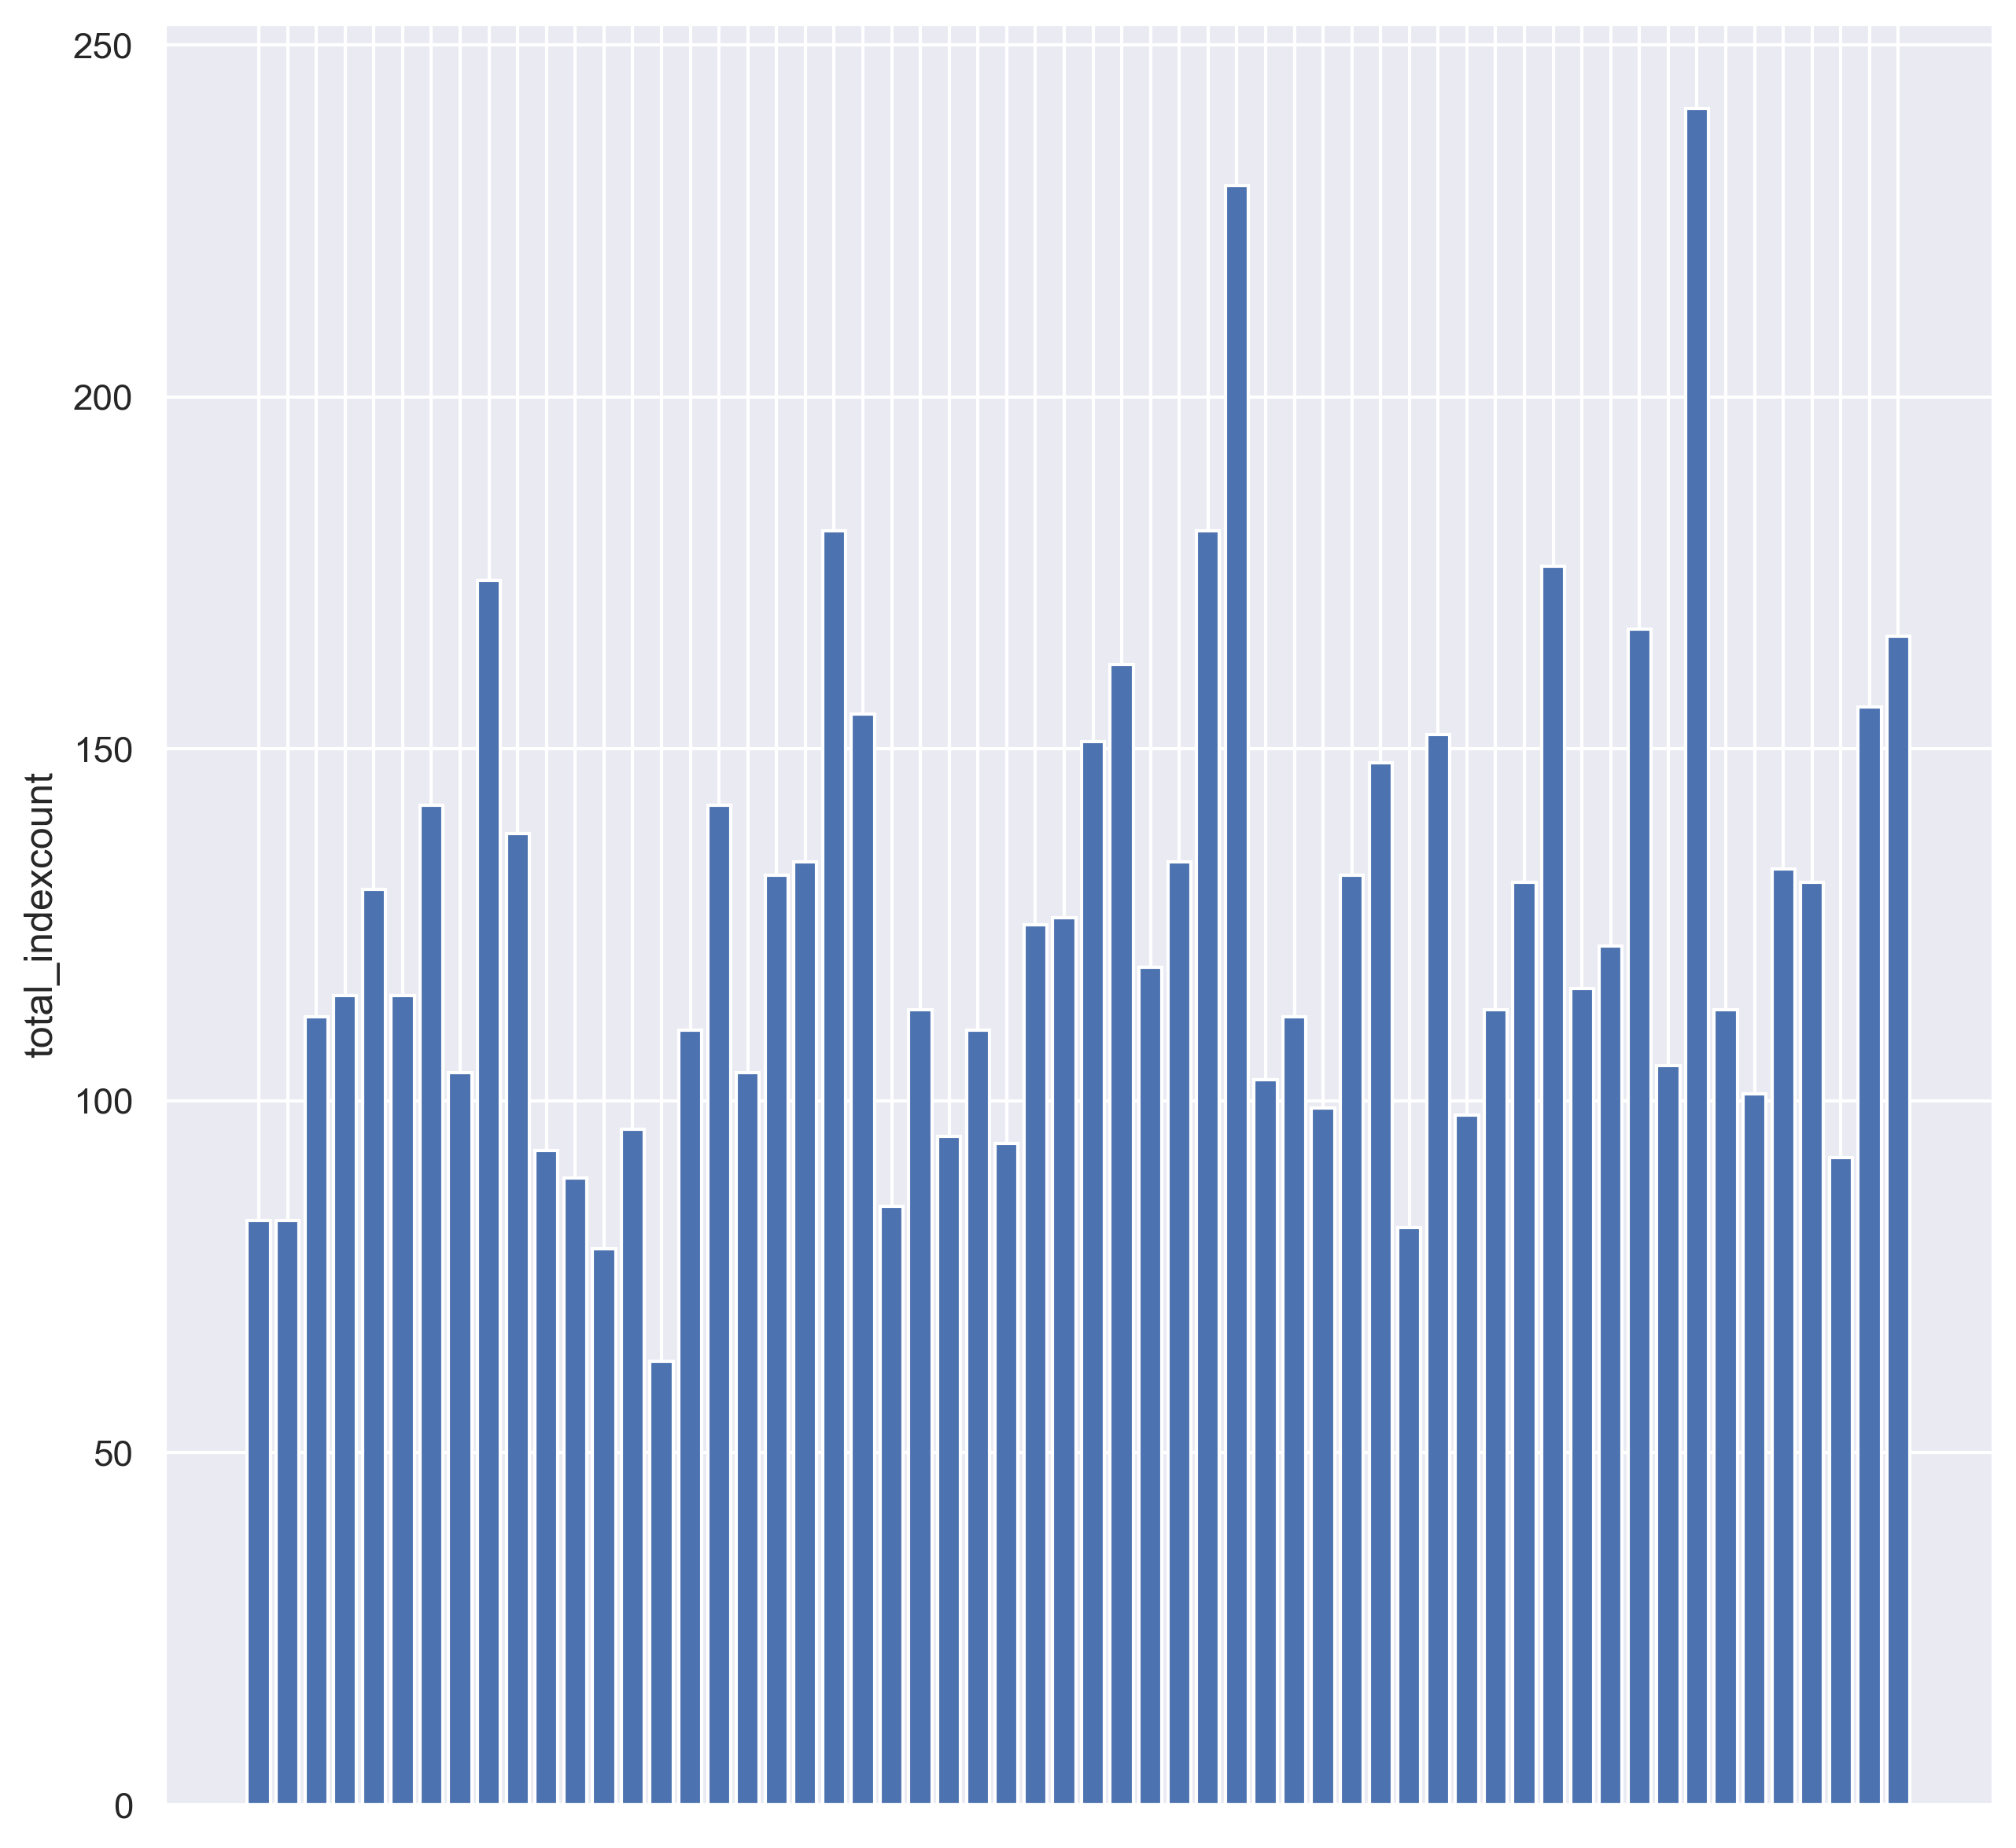

In [13]:
#Plotting total count (removing 'unmapped')
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
sns.set()
ax1.bar(test[0:58].index, test[0:58].sum(axis=1))
ax1.set_ylabel('total_indexcount')
ax1.axes.xaxis.set_ticklabels([])
plt.savefig(out_path + '_pos_indexes_count.pdf')

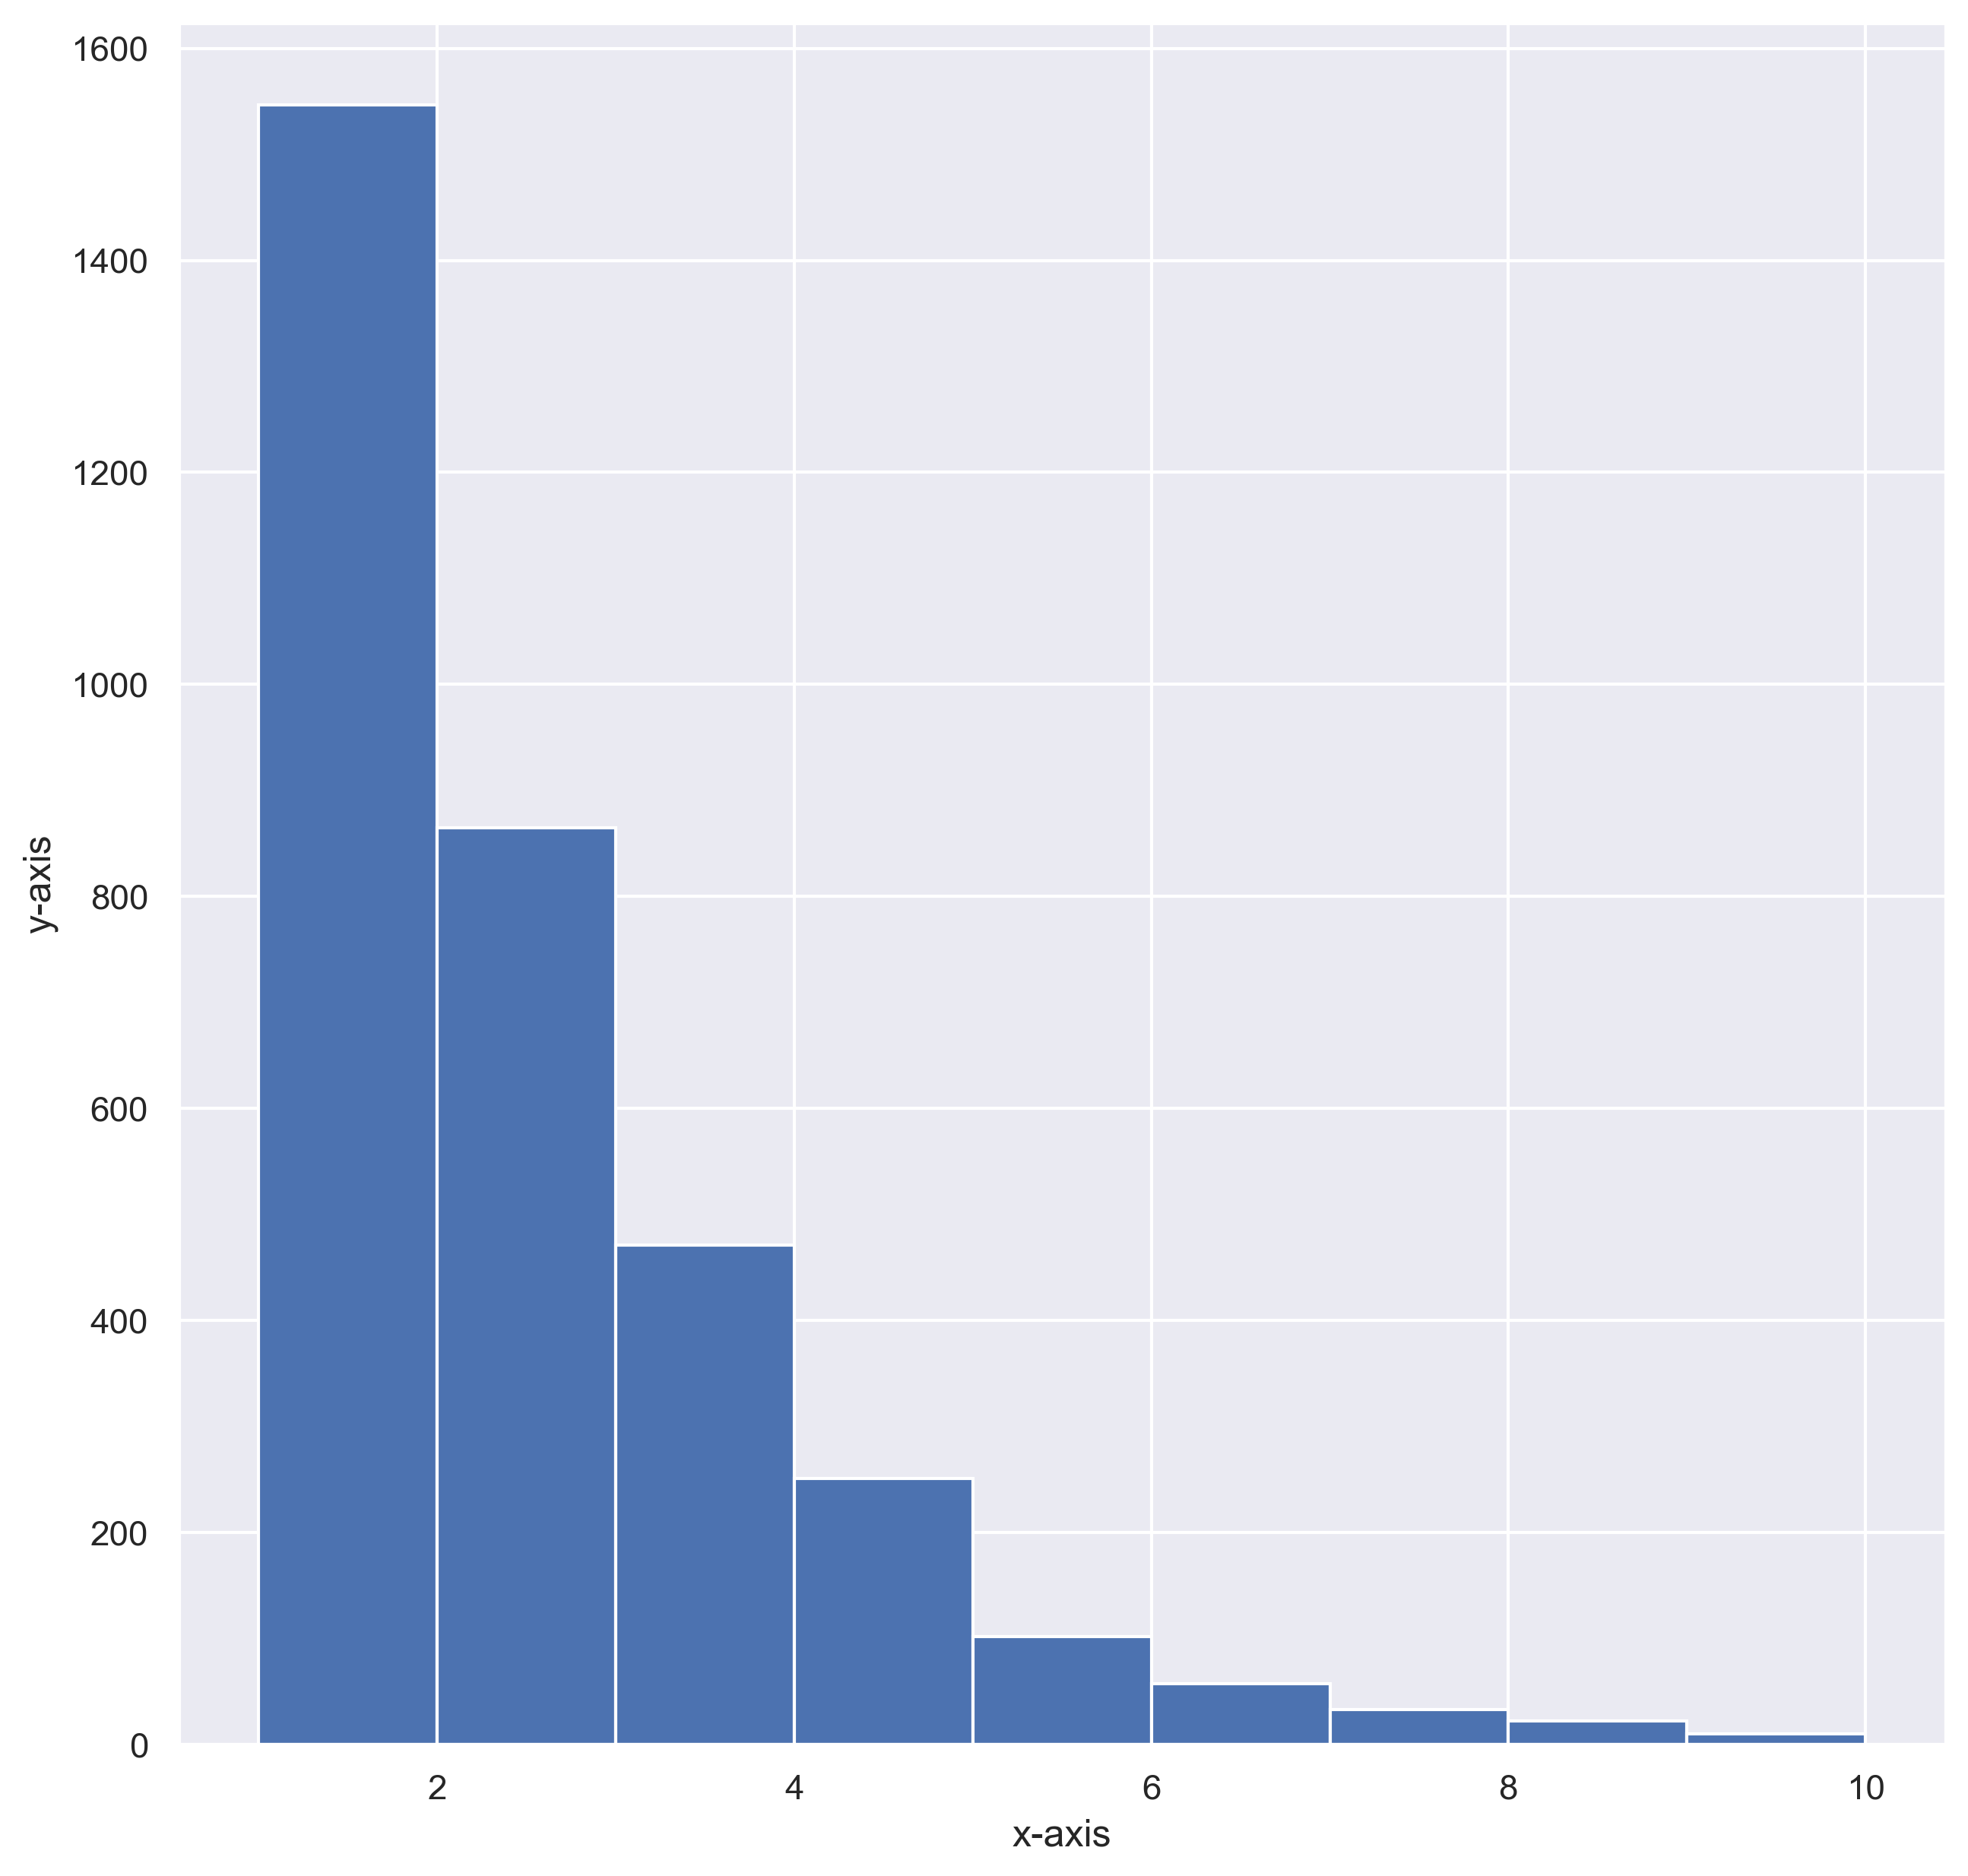

In [14]:
#Plotting total count (removing 'unmapped')
fig, ax1 = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
sns.set()
ax1.set(xlabel ='x-axis', ylabel='y-axis')
ax1.hist(test.apply(lambda x: x[0:58].sum()), range=(1, 10), bins= 9)
plt.savefig(out_path + '_pos_indexes_hist.pdf')

In [15]:
print('Mean_num_indexes_per_cell: ' + str(np.mean(test.apply(lambda x: x[0:58].sum()))))

Mean_num_indexes_per_cell: 2.1581285164347053


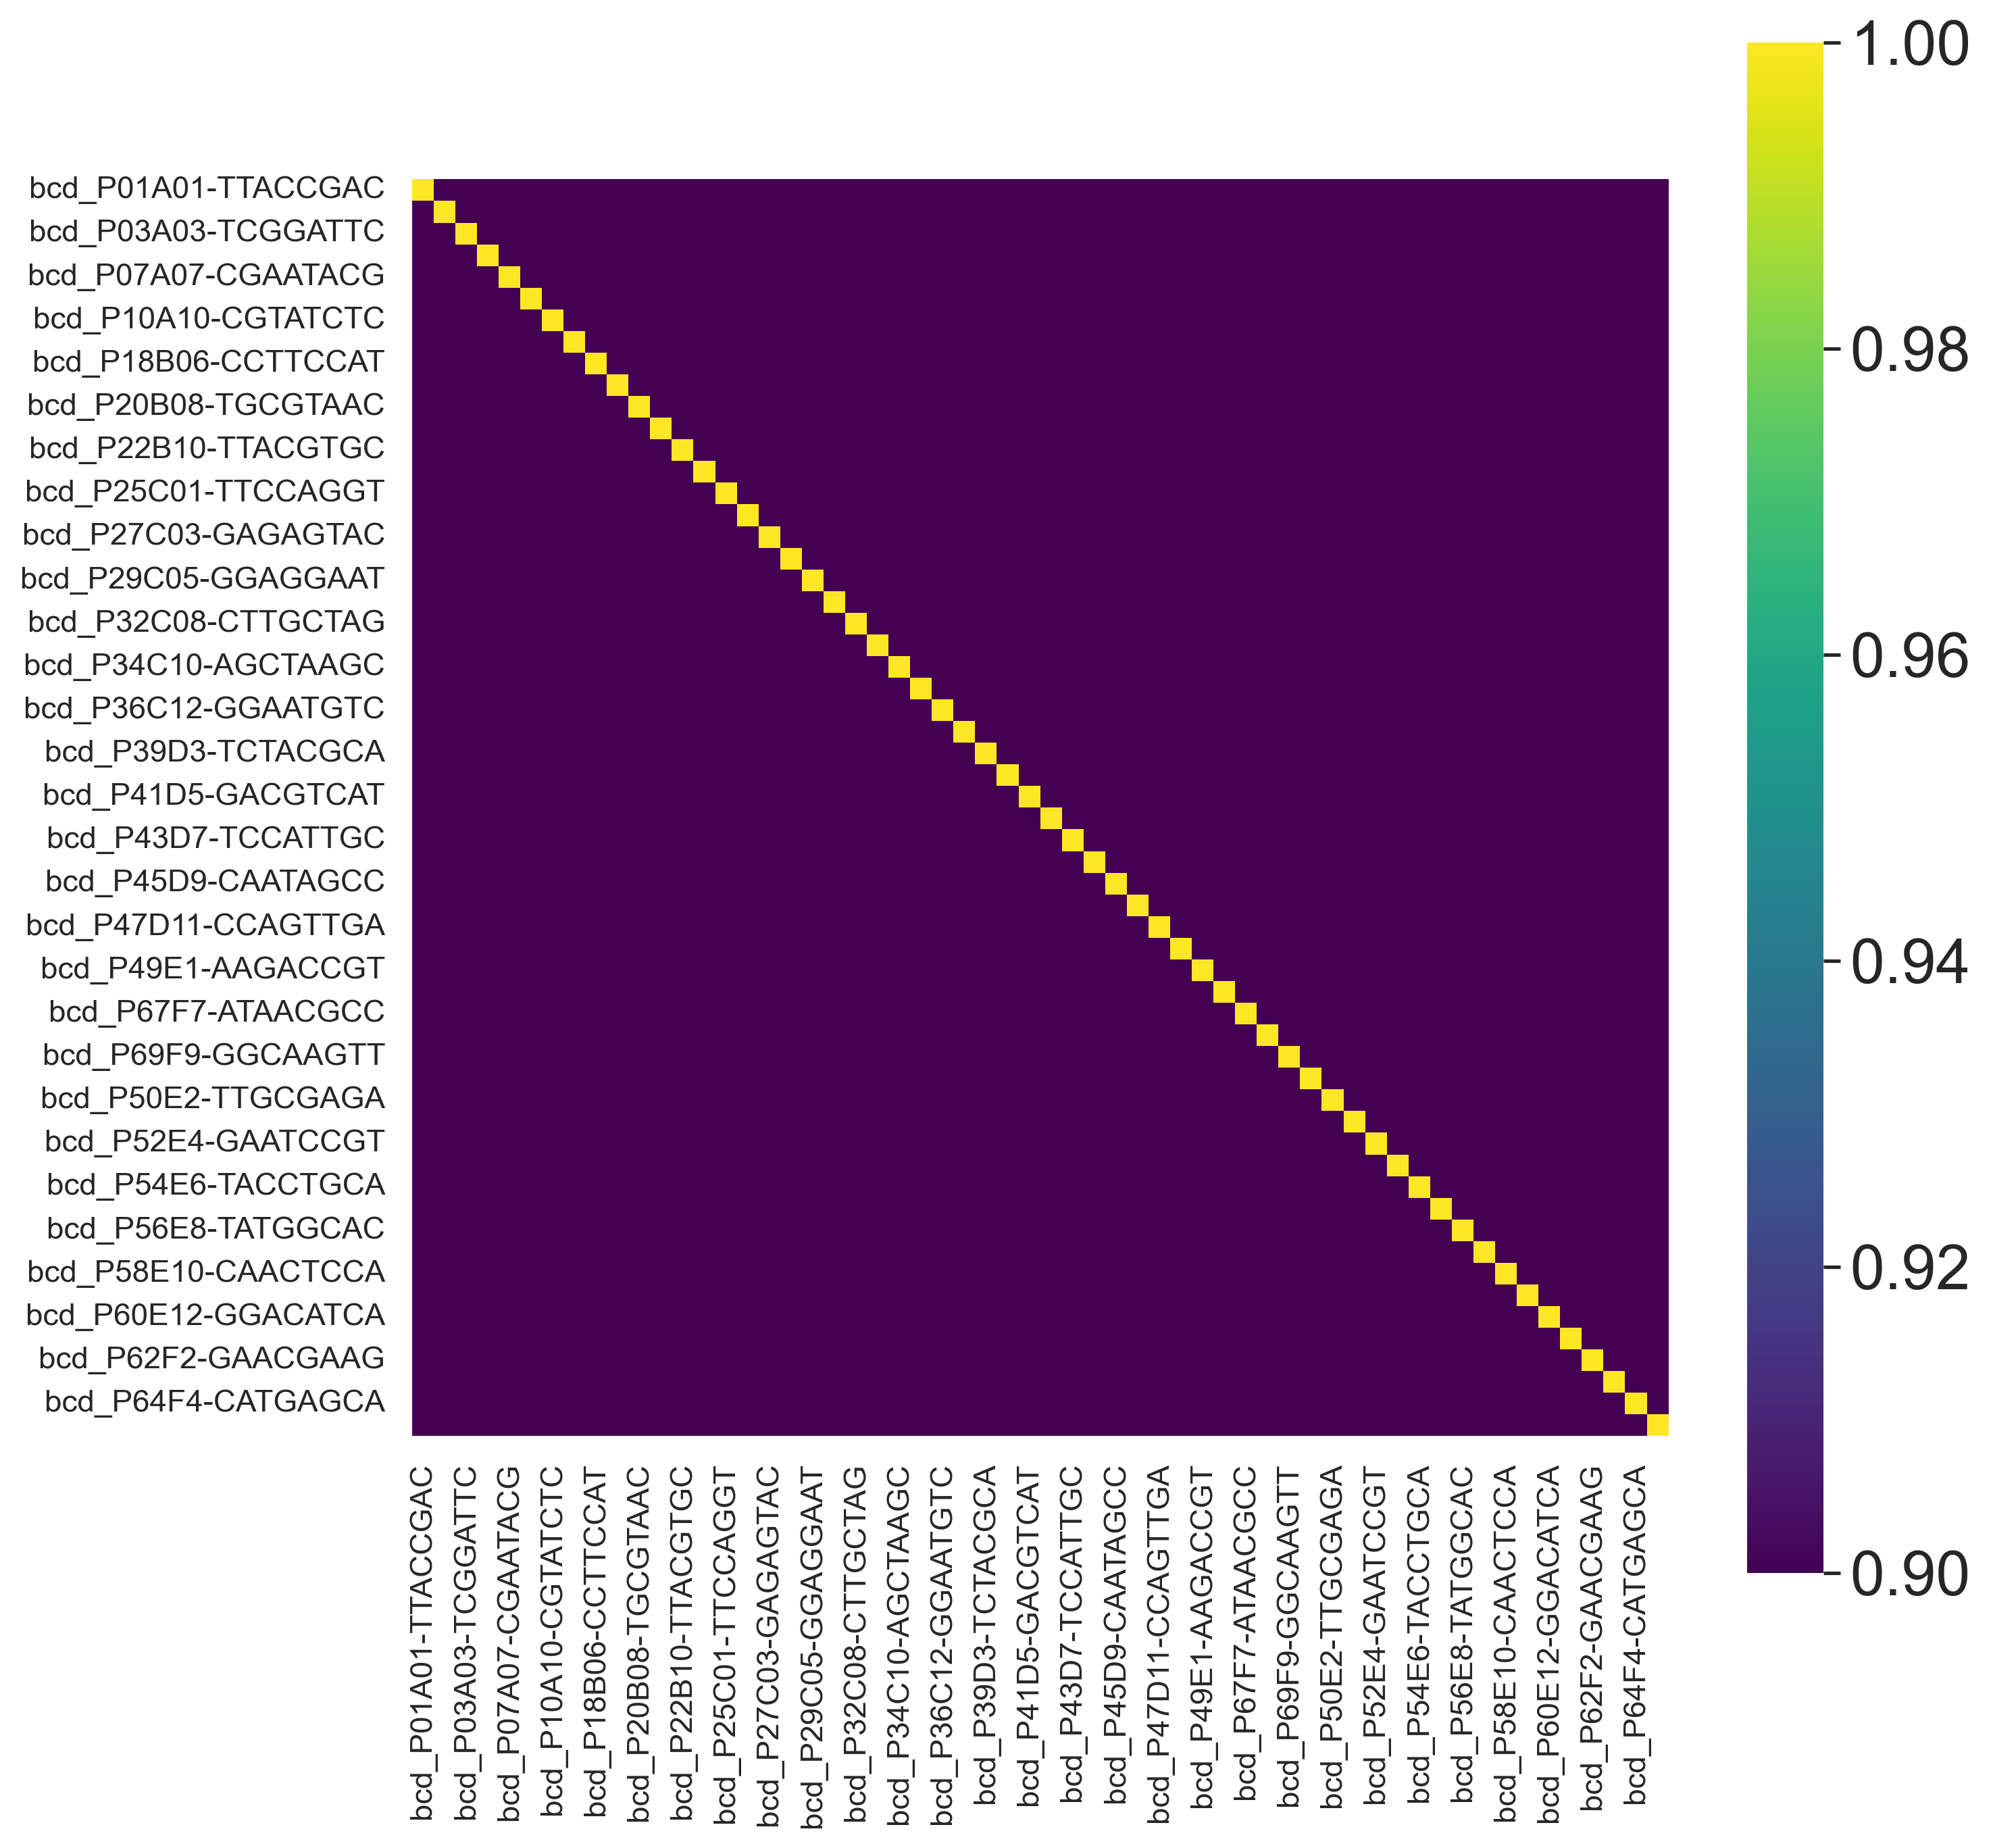

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=300)
sns.set(font_scale = 2)
sns.heatmap(test[0:58].T.corr(), vmin=0.9, square=True, ax=ax, cmap='viridis')
plt.savefig(out_path + '_poscorr.pdf')

In [17]:
num_beads = [2,3,4,5]

In [18]:
for i in range(len(num_beads)):
    cond = str(num_beads[i]) + '-9_'

    tab3 = pd.read_csv(out_prefix + '.pos_signals.txt.gz', sep='\t', index_col=0) 
    tab3 = tab3.loc[:, tab3.apply(lambda x: x[0:58].sum()) > num_beads[i]-1]
    tab3 = tab3.loc[:, tab3.apply(lambda x: x[0:58].sum()) < 10] 
    
    temp = pd.DataFrame(tab3.T)
    print(cond + ": data points after filtering " + str(len(temp)))
    temp['idx'] = 0

    for k in range(0, len(temp)):
        temp.iloc[k,58] = ''.join(str(s) for s in temp.iloc[k,0:58].tolist())
    temp=temp.sort_values(by=['idx'])
    temp.iloc[:,58].to_csv(out_path  + '_' + cond + 'pattern.txt', sep='\t', header=True)

2-9_: data points after filtering 1808
3-9_: data points after filtering 943
4-9_: data points after filtering 472
5-9_: data points after filtering 221
